In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## 1. Decision Trees

### A. Implement Decision Tree

In [2]:
#reading the data
df = pd.read_csv("nursery_data.txt")

In [3]:
#splitting into X and y columns and encoding the target labels
X, y = df.iloc[:,:-1],df.iloc[:,-1]
target_encoder = LabelEncoder()
y_transformed = target_encoder.fit_transform(y)

In [4]:
train_ratio = 0.70 
validation_ratio = 0.15
test_ratio = 0.15

# train is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=1 - train_ratio, random_state=3116)

# test is now 15% of the initial data set
# validation is now 15% of the initial data set
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=3116) 

In [5]:
#make dataframes of all the training, validation and test sets
y_train = pd.DataFrame(y_train,index=X_train.index)
y_test = pd.DataFrame(y_test,index=X_test.index)
y_valid = pd.DataFrame(y_valid,index=X_valid.index)

In [6]:
class Node:
    """
    Class which represent a simple node in a decision tree
    """
    def __init__ (self, probs=None, feature=None, condition=None, left_subtree=None, right_subtree=None, leaf_val=None):
        self.probs = probs #probability of a instance coming to node belonging to different classes
        self.feature = feature #the feature which the node checks
        self.condition = condition #the condition or threshold
        self.left_subtree = left_subtree #left subtree of the node
        self.right_subtree = right_subtree #right subtree of the node
        self.leaf_val = leaf_val #leaf value that the node has

In [59]:
class DecisionTreeClf:
    """
    Decision Tree Classifier Class which implements the Decision tree based on MCR as a quality criterion and Information Gain
    """
    def __init__ (self, criterion, max_depth, min_samples_per_leaf, classes_name, tolerance=0.01):
        self.max_depth = max_depth #max_depth which the tree can grow
        self.min_samples_per_leaf = min_samples_per_leaf #min number of samples in each node
        self.root = None #root node
        self.criterion = criterion #criterion this can be MCR or Entropy
        self.classes_name= classes_name #names of classses which the data represents
        self.best_gains = [] #list to store gains at each decision step, useful for visualizations
        self.tolerance = tolerance #stopping criteria when gain is too small or reduction in cost is small
        
    def fit(self, X, y):
        self.cat_types = self.cols_cat_list(X) #it is important to know what is the types of columns
        self.num_cats = np.max(np.unique(y))+1 #number of classes in the data
        data = pd.concat([X,y],axis=1) #concatenating data and target as they are easier to deal with
        self.root = self.grow_tree(data) #growing the tree from the root node
        
    def predict(self, X):
        preds = [] #list to store predictions
        for _,x in X.iterrows(): #iterating over one row at a time
            preds.append(self.forward_traverse(x, self.root)[0]) #storing the predictions for each observation
        return preds
        
    def misclassification_rate(self, y):
        pred = np.zeros(self.num_cats) #initialize the empty vector which represents the probability of each class
        val, counts = np.unique(y,return_counts=True) #counts the number of unique classes
        pred[val] = counts #set the count as initial prediction(in next step this will be converted to probability)
        probs = pred/np.sum(pred) #convert the count into probability
        return -(1-np.max(probs)) #We will maximize the -ve MCR which is equal to minimizing MCR
    
    def entropy(self, y):
        #to calculate the information gain entropy function will be useful
        class_labels = np.unique(y) #unique class labels
        entropy = 0 #set initial entropy as zero
        for cls in class_labels: #iterate over each class and calculate its entropy
            p_cls = len(y[y == cls]) / len(y) #propability of the class
            entropy += -p_cls * np.log2(p_cls) #entropy
        return entropy
    
    def information_gain(self, parent, left_y, right_y):
        weight_l = len(left_y)/len(parent) #weight of left node
        weight_r = len(right_y)/len(parent) #weight of right node
        if self.criterion == "MCR": #quality criterion as MCR and Information gain is handled differently
            return weight_l*self.misclassification_rate(left_y)+weight_r*self.misclassification_rate(right_y)
        elif self.criterion == "Entropy":
            return self.entropy(parent) - (weight_l * self.entropy(left_y) + weight_r * self.entropy(right_y))
    
    def split_data(self, data, feature, condition):
        #first to get the datatype of the presented feature
        data_type = data[feature].dtype
        
        #numeric and categoric columns are handled differently
        if data_type == 'O': 
            left_data = data[data[feature]==condition]
            right_data = data[data[feature]!=condition]
            
        else:
            left_data = data[data[feature]<condition]
            right_data = data[data[feature]>=condition]
            
        return left_data, right_data
            
    def get_leaf_value(self,y):
        pred = np.zeros(self.num_cats) #initialize the empty probability vector
        val, counts = np.unique(y,return_counts=True) #count unique ys
        pred[val] = counts #set the count to probability vector
        probs = pred/np.sum(pred) #convert counts into probability
        return probs
    
    def cols_cat_list(self,data):
        #this function helps in separating categoric columns from numeric ones
        col_types = {}
        for col in data.columns:
            if data[col].dtype == 'O':
                col_types[col] = 'cat'
            else:
                col_types[col]='num'
        return col_types
    
    def best_split(self, data):
        
        best_split = {} #dictionary to store information about the best split
        best_gain = -np.inf #since we want to maximize the gain so start with smallest number
        
        #start iterating over each column, one by one till the target
        for feat in data.columns[:-1]:
            #numeric and categorical column will be handled differently
            data_type = data[feat].dtype
            
            #for categorical features
            if data_type == 'O':
                v = np.unique(data[feat]) #to get the unique values in this feature
                for cond in v: #iterating over each unique value
                    left_data, right_data = self.split_data(data, feat, cond) #splitting the data based on current value
                    
                    #this avoids unnecessary splits
                    if len(left_data)>0 and len(right_data)>0:
                        #to get the labels of each datasets
                        data_y, left_y, right_y = data.iloc[:,-1], left_data.iloc[:,-1], right_data.iloc[:,-1]
                        #calculate the quality criterion/informatin gain of the current split
                        gain = self.information_gain(data_y,left_y,right_y)
                        #store the information of the best split
                        if gain>best_gain:
                            best_gain=gain
                            best_split['feature'] = feat
                            best_split['condition'] = cond
                            best_split['gain'] = gain
                            best_split['left_data'] = left_data
                            best_split['right_data'] = right_data
            
            #for numeric features
            else:
                v = sorted(list(set(data[feat]))) #this aranges all the unique numeric column into ascending order
                means = [(v[i] + v[i+1]) / 2 for i in range(len(v)-1)] #we will check on each threshold of the mean of entries
                for mean in means: #iterating over each means
                    left_data, right_data = self.split_data(data, feat, mean) #splitting the data
                    #this avoids unnecessary splits
                    if len(left_data)>0 and len(right_data)>0:
                        #to get the labels of each datasets
                        data_y, left_y, right_y = data.iloc[:,-1], left_data.iloc[:,-1], right_data.iloc[:,-1]
                        #calculate the quality criterion/informatin gain of the current split
                        gain = self.information_gain(data_y,left_y,right_y)
                        #store the information of the best split
                        if gain>best_gain:
                            best_gain=gain
                            best_split['feature'] = feat
                            best_split['condition'] = mean
                            best_split['gain'] = gain
                            best_split['left_data'] = left_data
                            best_split['right_data'] = right_data
        return best_split
    
    def grow_tree(self,data,curr_depth=0):
        #separate the labels
        labels = data.iloc[:,-1]
                
        #count the unique labels in the target set
        n_labels = len(np.unique(labels))
        
        #count the number of samples in the data, 
        samples = data.shape[0]
        
        #to get the empty vector to store probabilities
        probs = np.zeros(self.num_cats)
        p = labels.value_counts()/labels.value_counts().sum()
        
        #to get the probability of each class
        for i,v in p.items():
            probs[i] = v
        
        #now first checking the stopping condition
        if samples < self.min_samples_per_leaf or n_labels==1 or curr_depth>self.max_depth:
            #print(n_labels, samples, curr_depth)
            return Node(probs,leaf_val = np.argmax(self.get_leaf_value(data.iloc[:,-1])))
        
        #if stopping condition is not met, then we will split the data based on the best split
        best_split = self.best_split(data)
        feat = best_split['feature']
        condition = best_split['condition']
        gain = best_split['gain']
        left_data = best_split['left_data']
        right_data = best_split['right_data']
        
        if (len(self.best_gains)> 1) and np.abs(gain - self.best_gains[-1])<self.tolerance:
            return Node(probs,leaf_val = np.argmax(self.get_leaf_value(data.iloc[:,-1])))
        
        else:
            self.best_gains.append(gain)
        
        
        #adds left and right nodes recursively
        left_subtree = self.grow_tree(left_data,curr_depth+1)
        right_subtree = self.grow_tree(right_data,curr_depth+1)
        return Node(probs,feat,condition,left_subtree,right_subtree)
    
    def forward_traverse(self, data, node):
        #first check if the current node is the leaf node
        if node.leaf_val is not None:
            return node.leaf_val,node.probs
        
        #if it's a decision node
        feat = node.feature
        cond = node.condition
        left_subtree = node.left_subtree
        right_subtree = node.right_subtree
        
        #first we will check the datatype of the feature
        data_type = self.cat_types[feat]
        
        #for categoric feature
        if data_type == 'cat':
            if data[feat] == cond:
                return self.forward_traverse(data,left_subtree)
            return self.forward_traverse(data, right_subtree)
        
        #for numeric feature     
        else:
            if data[feat] < cond:
                return self.forward_traverse(data,left_subtree)
            return self.forward_traverse(data, right_subtree)
        
    def plot_histogram(self, node= None):
        #this function plots the histogram at each decision split
        if node is None:
            node = self.root
        
        if node.leaf_val is not None:
            plt.figure()
            plt.xlabel("Target Class")
            plt.ylabel("Probability")
            plt.title(f"Histogram of Probabilites at Leaf Node")
            plt.bar(self.classes_name,node.probs)
            plt.show()
            
        else:   
            feat = node.feature
            cond = node.condition
            plt.figure()
            plt.xlabel("Target Class")
            plt.ylabel("Probability")
            plt.title(f"Histogram of Probabilites at Decision {feat} == {cond}")
            plt.bar(self.classes_name,node.probs)
            plt.show()

            self.plot_histogram(node.left_subtree)
            self.plot_histogram(node.right_subtree)
            
    def print_tree(self, node=None, indent=1):
        #to print the tree
        if node is None:
            node = self.root
        
        if node.leaf_val is not None:
            print(f"Leaf Node Value:{self.classes_name[np.argmax(node.leaf_val)]}")
            
        else:   
            feat = node.feature
            cond = node.condition
            print(f"Decision: {node.feature} == {node.condition}")
            print("|"*indent + "left :", end="")
            self.print_tree(node.left_subtree,indent+1)
            print("|"*indent + "right:", end="")
            self.print_tree(node.right_subtree,indent+1)
            
    def calculate_loss(self, x, y):
        loss = [] #to store the loss of each samples
        for i in range(len(x)):
            #calculate the cross entropy loss of each sample
            loss.append(np.log(self.forward_traverse(x.iloc[i,:], self.root)[1][y.iloc[i,:]][0]+1e-12))
        return -np.sum(loss)/len(loss)
    
    def plot_information_gain(self):
        #to plot the information gain
        plt.figure()
        plt.xlabel("Split Number")
        plt.ylabel("Information Gain")
        plt.title(f"Plot of Information Gain at each Decision")
        plt.plot(np.arange(len(self.best_gains)),self.best_gains)
        plt.show()

In [73]:
#main function which do the training by radomly selecting hyperparms from the given grid
def run(config,num_trials, X_data, y_data, X_valid, y_valid):
    best_loss = np.inf #to track the min loss
    best_acc = -np.inf #to track max accuracy
    best_model = None
    bestp = None #to track the best params
    for _ in range(num_trials): #trying the random search training for n times
        #to train the tree
        val_acc, val_loss, rand_config, model = training_function(config, X_data, y_data, X_valid, y_valid)
        #to store the tree with lowest validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_acc = val_acc
            bestp = rand_config
            best_model = model
    return best_acc, best_loss, bestp, best_model

In [74]:
#function to randomly select/subsample hyperparameters to be used for training
def random_select(config):
    rand_config={} #dictionary to select random sample
    for k,v in config.items():
        m = len(v)
        r_val = v[np.random.randint(0,m)]
        rand_config[k] = r_val
    return rand_config

In [75]:
#function to do the training of the tree based on the randomly picked hyper params
def training_function(config, X_data, y_data, X_valid, y_valid):
    #randomly select the variables
    rand_config = random_select(config)
    
    #get the variables
    max_depth = rand_config["max_depth"]
    min_samples_per_leaf = rand_config["min_samples_per_leaf"]
    tolerance = rand_config["tolerance"]
    criterion = rand_config["criterion"]
    classes_name = target_encoder.classes_
    
    print(f"Currently Selected Params are max_depth:{max_depth}, min_samples_per_leaf:{min_samples_per_leaf}, gain_tolerance:{tolerance}")
    #make the model
    model = DecisionTreeClf(criterion,max_depth,min_samples_per_leaf,classes_name,tolerance)
    #train and test the model on validation set
    model.fit(X_data, y_data)
    preds = model.predict(X_valid)
    acc_score = accuracy_score(y_valid,preds)
    loss = model.calculate_loss(X_valid,y_valid)
    print(f'The Validation Accuracy is {acc_score} and Validation loss is {loss}\n')
    return acc_score, loss, rand_config, model

In [76]:
search_space = {
    "max_depth":[2,3,5,10,15],
    "min_samples_per_leaf":[2,3,4,5,10],
    "tolerance": [0.1,0.01,0.001,0.002],
    "criterion":["MCR"]
}

NUM_TRIALS = 10 #number of times the random search has to be performed
max_acc, best_loss, best_p, tree_clf = run(search_space, NUM_TRIALS, X_train, y_train, X_valid, y_valid)

Currently Selected Params are max_depth:5, min_samples_per_leaf:3, gain_tolerance:0.01
The Validation Accuracy is 0.8858024691358025 and Validation loss is 0.32494846167390506

Currently Selected Params are max_depth:2, min_samples_per_leaf:10, gain_tolerance:0.1
The Validation Accuracy is 0.8395061728395061 and Validation loss is 0.4404488579574148

Currently Selected Params are max_depth:5, min_samples_per_leaf:5, gain_tolerance:0.002
The Validation Accuracy is 0.8966049382716049 and Validation loss is 0.31328112126930524

Currently Selected Params are max_depth:15, min_samples_per_leaf:5, gain_tolerance:0.001
The Validation Accuracy is 0.9295267489711934 and Validation loss is 0.9087197359604969

Currently Selected Params are max_depth:5, min_samples_per_leaf:3, gain_tolerance:0.1
The Validation Accuracy is 0.8395061728395061 and Validation loss is 0.4404488579574148

Currently Selected Params are max_depth:5, min_samples_per_leaf:2, gain_tolerance:0.01
The Validation Accuracy is 0.

To get the features which gave the best result on validation set

In [77]:
best_p

{'max_depth': 5,
 'min_samples_per_leaf': 5,
 'tolerance': 0.002,
 'criterion': 'MCR'}

These parameters gave the accuracy of 0.924 on validation set. Let's also calculate on test set.

In [78]:
print('The accuracy of finetuned model on test set is', accuracy_score(y_test,tree_clf.predict(X_test)))

The accuracy of finetuned model on test set is 0.8920308483290489


Since our best model has the depth of 15, printing it's histogram at each decision step would be too lengthy. Alternatively we can display the histogram plots and tree structure on a smaller tree. The same method can be call on tree of any size.

In [52]:
tree_qc = DecisionTreeClf("MCR",max_depth=3,min_samples_per_leaf=3,classes_name=target_encoder.classes_)
tree_qc.fit(X_train,y_train)

1. At each decision step (or split) present the probability of each class using histogram (properly labeled
figure)

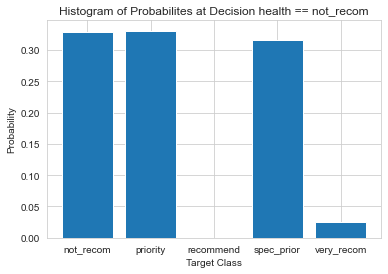

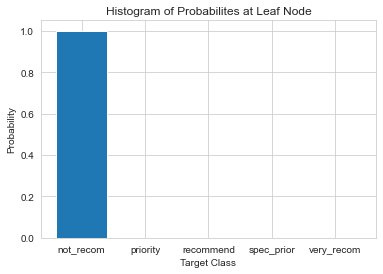

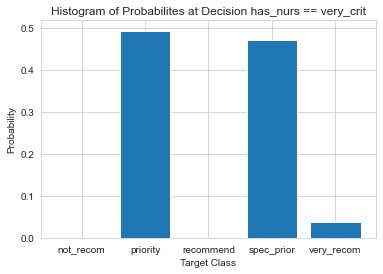

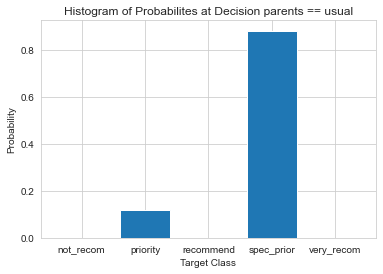

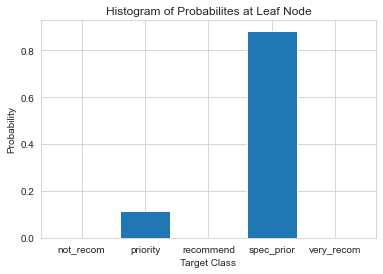

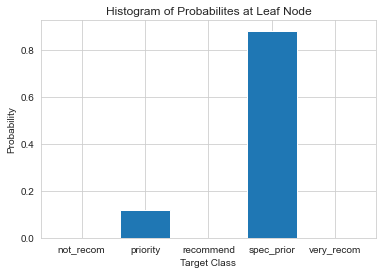

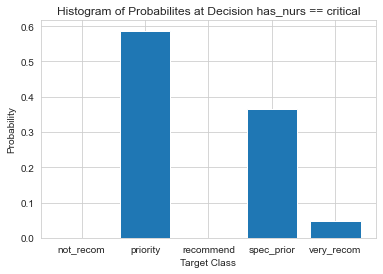

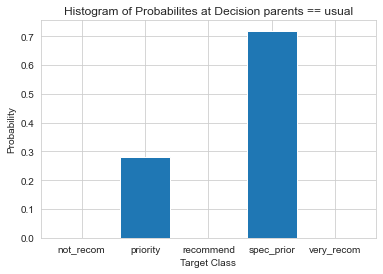

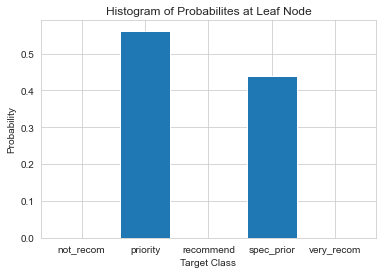

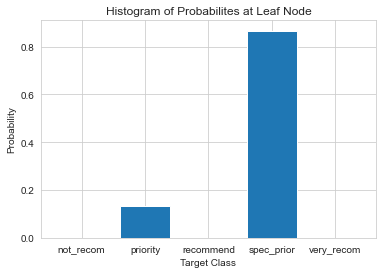

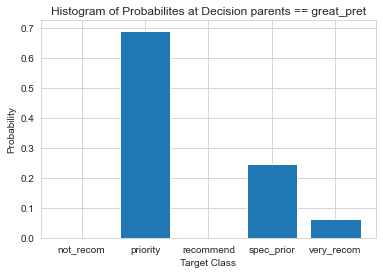

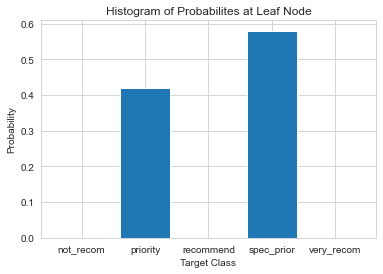

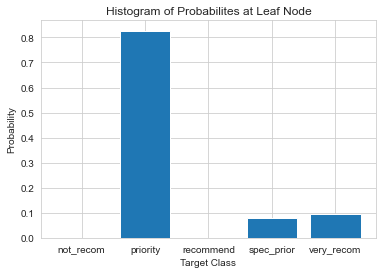

In [53]:
tree_qc.plot_histogram()

2. Print your tree using a breath first tree traversal.

In [54]:
tree_qc.print_tree()

Decision: health == not_recom
|left :Leaf Node Value:not_recom
|right:Decision: has_nurs == very_crit
||left :Decision: parents == usual
|||left :Leaf Node Value:not_recom
|||right:Leaf Node Value:not_recom
||right:Decision: has_nurs == critical
|||left :Decision: parents == usual
||||left :Leaf Node Value:not_recom
||||right:Leaf Node Value:not_recom
|||right:Decision: parents == great_pret
||||left :Leaf Node Value:not_recom
||||right:Leaf Node Value:not_recom


3. On the validation-set measure the cross entropy loss (i.e. logloss, note that this time problem is not binary
classification).

In [55]:
val_qc = tree_qc.calculate_loss(X_valid,y_valid)
print('On validation set the cross entropy loss is', val_qc)

On validation set the cross entropy loss is 0.3569935872468654


In [79]:
#let's also calculate loss from best_model
val_ = tree_clf.calculate_loss(X_valid,y_valid)
print('On validation set the cross entropy loss of the finetuned model is', val_)

On validation set the cross entropy loss of the finetuned model is 0.31328112126930524


### B. Experimenting with other Quality-criterion

Now, fine tune the Tree model using the Information Gain

In [81]:
search_space = {
    "max_depth":[2,3,5,10,15],
    "min_samples_per_leaf":[2,3,4,5,10],
    "tolerance": [0.1,0.01,0.001,0.002],
    "criterion":["Entropy"]
}

NUM_TRIALS = 10 #number of times the random search has to be performed
max_acc, best_loss, best_p, tree_clf_ig = run(search_space, NUM_TRIALS, X_train, y_train, X_valid, y_valid)

Currently Selected Params are max_depth:2, min_samples_per_leaf:5, gain_tolerance:0.001
The Validation Accuracy is 0.8184156378600823 and Validation loss is 0.4473587122219477

Currently Selected Params are max_depth:2, min_samples_per_leaf:2, gain_tolerance:0.001
The Validation Accuracy is 0.8184156378600823 and Validation loss is 0.4473587122219477

Currently Selected Params are max_depth:10, min_samples_per_leaf:2, gain_tolerance:0.001
The Validation Accuracy is 0.9789094650205762 and Validation loss is 0.10450943612997131

Currently Selected Params are max_depth:2, min_samples_per_leaf:2, gain_tolerance:0.001
The Validation Accuracy is 0.8184156378600823 and Validation loss is 0.4473587122219477

Currently Selected Params are max_depth:15, min_samples_per_leaf:5, gain_tolerance:0.002
The Validation Accuracy is 0.9938271604938271 and Validation loss is 0.07519814283536895

Currently Selected Params are max_depth:15, min_samples_per_leaf:3, gain_tolerance:0.1
The Validation Accuracy 

In [82]:
#to get the best params
best_p

{'max_depth': 15,
 'min_samples_per_leaf': 5,
 'tolerance': 0.002,
 'criterion': 'Entropy'}

These parameters gave the accuracy of 0.993 on validation set. Let's also calculate on test set

In [83]:
print('The accuracy of finetuned model on test set is', accuracy_score(y_test,tree_clf_ig.predict(X_test)))

The accuracy of finetuned model on test set is 0.9974293059125964


In [85]:
val_ig = tree_clf_ig.calculate_loss(X_valid,y_valid)
print('On validation set the cross entropy loss is', val_ig)

On validation set the cross entropy loss is 0.07519814283536895


Comparison: When we used Misclassification rate as the split criteria, we got validation loss and validation accruacy as 0.313, 0.89 and on test set we got similar 0.89 (While finetuning some trees gave upto 0.92 accuracy on validation set however they were discarded as we are only tracking the tree with minimum validation loss). When we used Information gain as a quality criterion we got validation loss and validation accruacy as 0.993, 0.075 and on test set we got 0.99 accuracy. This is very remarkable how changing a criterion gave us the immense performance boost.

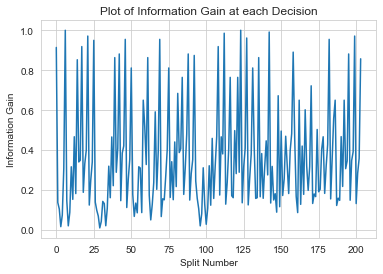

In [84]:
#to plot information gain at each decision step
tree_clf_ig.plot_information_gain()

To see how a plot looks, let's also plot on relatively shallow tree.

In [12]:
tree_ig = DecisionTreeClf("Entropy",max_depth=3,min_samples_per_leaf=3,classes_name=target_encoder.classes_)
tree_ig.fit(X_train,y_train)

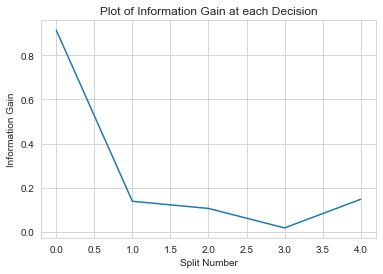

In [13]:
tree_ig.plot_information_gain()

## 2. Gradient Boosted Decision Trees 

In [86]:
from sklearn.datasets import make_moons

1. Generate a binary classification toy dataset from the scikit-learn utility ”make-moons”. Please generate 100 samples, for 10 different levels of noise which should give you a toy-dataset of 1000 samples. Here sample refers to a single point in 2-D, and it’s corresponding label (0 vs. 1) denoting membership in either of the two moons. Visualize the 10 different pairs of so-called moons.

In [87]:
X,y = np.empty(shape=(1,2)),np.empty(shape=(1,1))
for noise in np.linspace(0,0.5,10):
    dx,dy = make_moons(n_samples=100, shuffle=True, noise=noise, random_state=3116)
    X = np.concatenate((X,dx),axis=0)
    y = np.concatenate((y,dy.reshape(-1,1)),axis=0)

In [88]:
X = pd.DataFrame(X[1:],columns = ['x1','x2'])
y = pd.DataFrame(y[1:])

2. Generate train/validation/test splits with the ratios like before.

In [89]:
train_ratio = 0.70 
validation_ratio = 0.15
test_ratio = 0.15

# train is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=3116)

# test is now 15% of the initial data set
# validation is now 15% of the initial data set
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=3116) 

Visualize the 10 different pairs of so-called moons.

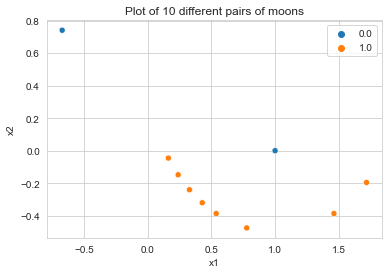

In [100]:
plt.title("Plot of 10 different pairs of moons")
sns.scatterplot(x=X['x1'][:10],y=X['x2'][:10],hue=y.values.ravel()[:10]);

The complete data looks like

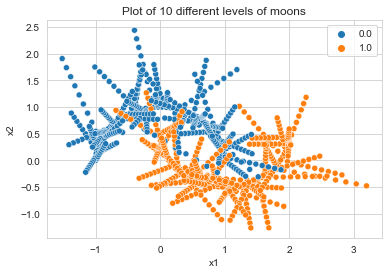

In [102]:
plt.title("Plot of 10 different levels of moons")
sns.scatterplot(x=X['x1'],y=X['x2'],hue=y.values.ravel());

In [104]:
class GradientBoostedTree(DecisionTreeClf):
    """
    Class to implement the gradient boosted tree for classification
    """
    def __init__ (self, num_trees=2, lambda_val=1, gamma_val=1, max_depth=2, min_samples_per_leaf=1, lr=0.3, classes_names=['0','1']):
        self.num_trees = num_trees #number of trees
        self.lambda_val = lambda_val #lambda value
        self.gamma_val = gamma_val #gamma value
        self.max_depth = max_depth #maximum depth
        self.min_samples_per_leaf = min_samples_per_leaf #mininum number of samples in each node
        self.lr = lr #learning rate
        self.classes_name = classes_names #name of classes in the dataset
        self.root = None #root node
        self.ensemble = [] #to store the roots of all trees
        
    def calculate_gradients(self, y_hat, y):
        #to calculate gradient
        return 1./(1+np.exp(-y_hat)) - y
    
    def calculate_hessians(self, y_hat):
        #to calculate hessians
        sigmoid = 1./(1+np.exp(-y_hat))
        return sigmoid * (1-sigmoid)
    
    def global_objective(self, y_cols):
        #to get global objective
        y_hat, y = y_cols.iloc[:,-1],y_cols.iloc[:,-2]
        gradients = self.calculate_gradients(y_hat,y)
        hessians = self.calculate_hessians(y_hat)
        return -1/2 * (np.sum(gradients)**2/(self.lambda_val + np.sum(hessians))) + self.gamma_val
    
    def information_gain(self, parent_obj, left_obj, right_obj):
        #to get information gain
        return self.global_objective(parent_obj) - (self.global_objective(left_obj) + self.global_objective(right_obj))
    
    def get_leaf_value(self, y_cols):
        #to get the value of the leaf node
        y_hat, y = y_cols.iloc[:,-1],y_cols.iloc[:,-2]
        grads = self.calculate_gradients(y_hat, y)
        hess = self.calculate_hessians(y_hat)
        w = -np.sum(grads)/(np.sum(hess) + self.lambda_val)
        sigmoid = 1./(1+np.exp(-w))
        return sigmoid
    
    def best_split(self, data):
        #dictionary to store information about the best split
        best_split = {}
        best_gain = -np.inf #since we want to maximize the gain so start with smallest number
        
        #start iterating over each column, one by one till the target
        for feat in data.columns[:-2]:
            #numeric and categorical column will be handled differently
            data_type = data[feat].dtype
            
            #for categorical features
            if data_type == 'O':
                v = np.unique(data[feat]) #to get the unique values in this feature
                for cond in v: #iterate over each unique value
                    left_data, right_data = self.split_data(data, feat, cond) #split the data
                    #to avoid unnecessary splits
                    if len(left_data)>0 and len(right_data)>0:
                        #to obtain targets of the parent, left and right node
                        data_y, left_y, right_y = data.iloc[:,-2:], left_data.iloc[:,-2:], right_data.iloc[:,-2:]
                        #to calculate the information gain
                        gain = self.information_gain(data_y,left_y,right_y)
                        #to keep the record of the best split
                        if gain>best_gain:
                            best_gain=gain
                            best_split['feature'] = feat
                            best_split['condition'] = cond
                            best_split['gain'] = gain
                            best_split['left_data'] = left_data
                            best_split['right_data'] = right_data
            
            #for numeric features
            else:
                v = sorted(list(set(data[feat]))) #this aranges all the unique numeric column into ascending order
                means = [(v[i] + v[i+1]) / 2 for i in range(len(v)-1)] #we will check on each threshold of the mean of entries
                for mean in means: #iterate over each mean
                    left_data, right_data = self.split_data(data, feat, mean) #split the data
                    #to avoid unnecessary splits
                    if len(left_data)>0 and len(right_data)>0:
                        #to obtain targets of parent, left and right node
                        data_y, left_y, right_y = data.iloc[:,-2:], left_data.iloc[:,-2:], right_data.iloc[:,-2:]
                        #to calculate the gain
                        gain = self.information_gain(data_y,left_y,right_y)
                        #to store the information associated with the best split
                        if gain>best_gain:
                            best_gain=gain
                            best_split['feature'] = feat
                            best_split['condition'] = mean
                            best_split['gain'] = gain
                            best_split['left_data'] = left_data
                            best_split['right_data'] = right_data
        return best_split
        
    def grow_tree(self,data,curr_depth=0):
        #separate the labels
        labels = data.iloc[:,-2]
                
        #count the unique labels in the target set
        n_labels = len(np.unique(labels))
        
        #count the number of samples in the data, 
        samples = data.shape[0]
        
        #to obtain the probability of each node
        probs = np.zeros(self.num_cats)
        p = labels.value_counts()/labels.value_counts().sum()
        
        for i,v in p.items():
            probs[int(i)] = v
        
        #now first checking the stopping condition
        if samples < self.min_samples_per_leaf or n_labels==1 or curr_depth>self.max_depth:
            #print(n_labels, samples, curr_depth)
            return Node(probs,leaf_val = self.get_leaf_value(data.iloc[:,-2:]))
        
        #if stopping condition is not met, then we will split the data based on the best split
        best_split = self.best_split(data)
        feat = best_split['feature']
        condition = best_split['condition']
        gain = best_split['gain']
        left_data = best_split['left_data']
        right_data = best_split['right_data']

        #adds left and right nodes recursively
        left_subtree = self.grow_tree(left_data,curr_depth+1)
        right_subtree = self.grow_tree(right_data,curr_depth+1)
        return Node(probs,feat,condition,left_subtree,right_subtree)
    
    def fit(self, X, y):
        #to get the categories of each column
        self.cat_types = self.cols_cat_list(X)
        #to get the unique classes present in the data
        self.num_cats = len(np.unique(y))
        p = pd.DataFrame(np.zeros(len(y)),index=y.index,columns=['y_hat'])
        data = pd.concat([X,y,p],axis=1) #concatenate the data and targets togather
        #making one tree at a time
        for num_tree in range(self.num_trees):
            tree = self.grow_tree(data) #to grow the tree
            self.ensemble.append(tree) #store the tree in the list
            #keep updating the residuals
            data.iloc[:,-1] = self.lr*data.iloc[:,-1] + np.array([self.forward_traverse(x,tree)[0] for _,x in X.iterrows()])
            
    def predict(self, X):
        preds = [] #to store the predicitons of each samples 
        for _,x in X.iterrows(): #iterting over each row
            pred = 0
            for tree in self.ensemble: #to grow one tree at a time
                pred = pred + self.lr * self.forward_traverse(x,tree)[0]
            preds.append(pred)
        return preds

3. Tuning number of trees in the ensemble on the validation set.

In [107]:
def tune_tree(nums_trees, X_train, y_train, X_valid, y_valid):
    best_acc = -np.inf
    best_model = None
    for n in nums_trees: #iterating over num_trees
        grad_tree = GradientBoostedTree(num_trees=n,max_depth=2)
        grad_tree.fit(X_train,y_train)
        p = grad_tree.predict(X_valid)
        print('The current number of trees are',n)
        acc = accuracy_score(y_valid,np.array(p)>0.5)
        print('The accuracy on validation set is',acc,'\n')
        if acc>best_acc:
            best_acc = acc
            best_model = grad_tree
        
    return best_acc, best_model

In [108]:
n_trees = [2,4,8,10,15,20]
acc, grad_tree = tune_tree(n_trees, X_train, y_train, X_valid, y_valid)

The current number of trees are 2
The accuracy on validation set is 0.49333333333333335 

The current number of trees are 4
The accuracy on validation set is 0.8466666666666667 

The current number of trees are 8
The accuracy on validation set is 0.8466666666666667 

The current number of trees are 10
The accuracy on validation set is 0.8466666666666667 

The current number of trees are 15
The accuracy on validation set is 0.5066666666666667 

The current number of trees are 20
The accuracy on validation set is 0.5066666666666667 



In [113]:
print('The Accuracy on the test set is',accuracy_score(y_test, np.array(grad_tree.predict(X_test))>0.5))

The Accuracy on the test set is 0.847682119205298


References:
1. https://github.com/Suji04/ML_from_Scratch/blob/master/decision%20tree%20classification.ipynb
2. https://www.youtube.com/watch?v=NxEHSAfFlK8